This notebook creates the graphics to visualize the difference between Static, Dynamic and Look-Ahead Scheduling

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolor

In [2]:
def Insert_row_(row_number, df, row_value): 
    # Slice the upper half of the dataframe 
    df1 = df[0:row_number] 
   
    # Store the result of lower half of the dataframe 
    df2 = df[row_number:] 
   
    # Inser the row in the upper half dataframe 
    df1.loc[row_number]=row_value 
   
    # Concat the two dataframes 
    df_result = pd.concat([df1, df2]) 
   
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
   
    # Return the updated dataframe 
    return df_result 

def assign_workers(testdata: pd.DataFrame,
                   isPPP: bool,
                   smooth_tips: bool,
                   Nworkers: int,
                   Ngenerations: int,
                   Nacceptances: int):
    
    current_gen=0
    workerclocks = np.zeros(Nworkers)
    current_acceptances = 0
    
    i=0
    
    indexworkercol=testdata_source.columns.get_loc('Worker #')
    indexstatuscol=testdata_source.columns.get_loc('Status')

    while i < len(testdata):
        
        #check if new generation started
        if testdata['Generation'].iloc[i] != current_gen:
            current_gen=testdata['Generation'].iloc[i]
            current_acceptances=0
            
            #insert wait times between generations
            if not isPPP and current_gen != Ngenerations+1 and current_gen != 1:
                new_gen_starttime = workerclocks.max()
                for k in range(Nworkers):
                    if k !=workerclocks.argmax():
                        row_value = [i, current_gen, "None", k + 1, new_gen_starttime-workerclocks[k]]
                        testdata=Insert_row_(i, testdata, row_value)
                        workerclocks[k]=new_gen_starttime
                        i += 1
        #assign worker            
        freeworker = workerclocks.argmin() + 1
        testdata.iloc[i, indexworkercol] = freeworker
        workerclocks[freeworker - 1] += testdata['Duration (ms)'].iloc[i]
        
        #check acceptance
        
        if testdata['Status'].iloc[i] == "Accepted":
            if current_acceptances < Nacceptances:
                current_acceptances += 1
            else:
                testdata.iloc[i,indexstatuscol]="Discarded"
        i += 1
    
    endtime=workerclocks.max()
    if smooth_tips:
        for k in range(Nworkers):
            last_process=testdata.loc[testdata['Worker #']==k+1].tail(1).index
            testdata.loc[last_process, "Duration (ms)"] = \
                testdata.iloc[last_process]["Duration (ms)"] + endtime-workerclocks[k]
    
    return testdata

In [3]:
def find_walltimes(testdata: pd.DataFrame, 
                   Nworkers: int, 
                   Ngenerations: int):
    
    walltimes = np.zeros((Ngenerations+1,Nworkers))
    processes = np.zeros(Nworkers)
    
    for i in range(0, Nworkers):
        for j in range(1, Ngenerations+1):
            testdata_worker = testdata.loc[testdata['Worker #']==i+1]
            testdata_worker_gen = testdata_worker.loc[testdata_worker['Generation']==j]
            testdata_worker_gen = testdata_worker_gen.assign(
                Walltime=lambda testdata_worker: testdata_worker_gen['Duration (ms)'].cumsum())
            walltimes[j,i] = walltimes[j-1,i]+testdata_worker_gen.tail(1)['Walltime']
            processes[i] = len(testdata_worker)
    return walltimes, processes


def create_arrays(testdata: pd.DataFrame, 
                  Nworkers: int, Ngenerations: int, 
                  Nmax_proc: int):
    
    runtimes_wp = np.zeros((int(Nmax_proc), Nworkers))
    generations_wp = np.zeros((int(Nmax_proc), Nworkers))
    acceptance_wp = [[None for x in range(Nworkers)] for y in range(int(Nmax_proc))]

    for i in range(0,Nworkers):
        testdata_worker = testdata.loc[testdata['Worker #']==i+1]
        runtimes = testdata_worker['Duration (ms)'].values
        generations = testdata_worker['Generation'].values
        acceptance = testdata_worker['Status'].array
        for j in range(len(runtimes)):
            runtimes_wp[j,i]=runtimes[j]
            generations_wp[j,i]=generations[j]
            acceptance_wp[j][i] = acceptance[j]
    return runtimes_wp, generations_wp, acceptance_wp


def create_colortable(color: dict, 
                     generations_wp: np.array,
                     acceptance_wp: np.array,
                     Nworkers: int, 
                     Nmax_proc: int):
    
    colortable = [[None for x in range(Nworkers)] for y in range(int(Nmax_proc))]

    for i in range(Nworkers):
        for j in range(int(Nmax_proc)):
            colortable[j][i]=color[str(int(generations_wp[j,i]))+str(acceptance_wp[j][i])]
    return colortable

In [4]:
def draw_picture(path: str,
                 colordict: dict, 
                 colortable: list, 
                 runtimes_wp: np.array,
                 walltimes: np.array,
                 Nworkers: int, 
                 Ngenerations: int, 
                 Nmax_proc: int, 
                 isPPP: bool,
                 y_max: int=0,
                 legend: bool=False):

    index = np.arange(Nworkers)+1
    bar_width = 0.7
    y_offset = np.zeros(Nworkers)
    
    if y_max == 0:
        y_max=walltimes.max()
        print(y_max)
    
    for row in range(int(Nmax_proc)):
        plt.bar(index, runtimes_wp[row]-10, bar_width, bottom=y_offset, color = colortable[row])
        y_offset = y_offset + runtimes_wp[row]

    for gen in range(1,Ngenerations):
        if isPPP:
            start_time = walltimes[gen,:].min()
            plt.axhline(start_time, linestyle='dashed', color ='black')
        end_time = walltimes[gen,:].max()
        plt.axhline(end_time, color = 'black')
    
    if Ngenerations==1:
        final_time=walltimes[1,:].max()
        plt.axhline(final_time, color = 'black')
    plt.xticks(index)
    plt.xlabel("worker")
    plt.ylabel("time")
    plt.ylim(0,y_max)
    
    
    if legend:
        plt.bar([1],[1],0, color = colordict["1Accepted"], label="Accepted")
        plt.bar([1],[1],0, color = colordict["1Rejected"], label="Discarded")
        plt.plot([1],[1], color='black', label="End of generation")
        plt.legend()
        
    plt.savefig(path)
    
    plt.show()

In [5]:
def generate_picture(testdata_source: pd.DataFrame, 
                     colordict: dict, 
                     path: str, 
                     isPPP: bool,
                     draw_source: bool,
                     Nacceptances: int, 
                     Nworkers: int,
                     smooth_tips: bool=False,
                     y_max: int=0,
                     legend: bool=False):
    
    Ngenerations = int(testdata_source['Generation'].max())    
    
    if draw_source:
        testdata=testdata_source
    else:
        testdata = assign_workers(testdata_source, isPPP, smooth_tips, Nworkers, Ngenerations, Nacceptances)
    
    if Nworkers==0:
        Nworkers = int(testdata['Worker #'].max())
        
    walltimes, processes = find_walltimes(testdata, Nworkers, Ngenerations)
    
    
    Nmax_proc = int(processes.max())
    
    runtimes_wp, generations_wp, acceptance_wp = create_arrays(testdata, Nworkers, Ngenerations, Nmax_proc)
    
    colortable = create_colortable(colordict, generations_wp, acceptance_wp, Nworkers, Nmax_proc)
    
    draw_picture(path, colordict, colortable, runtimes_wp, walltimes, Nworkers, Ngenerations, Nmax_proc,
                 isPPP, y_max, legend)

In [6]:
testdata_source = pd.read_csv(
    r'C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\TestDataConstructed.csv',
    delimiter = ";")
Nacceptances=20
Nworkers=8
colordict={'0None': 'white',
     '1None': 'white',
     '2None': 'white',
     '3None': 'white',
     '1Accepted': 'limegreen',
     '1Rejected': 'red',
     '1Discarded': 'palegreen',
     '2Accepted': 'dodgerblue',
     '2Rejected': 'red',
     '2Discarded': 'lightskyblue',
     '3Accepted': 'yellow',
     '3Rejected': 'red',
     '3Discarded': 'lemonchiffon'}

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

C:\Users\Felipe\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


1620.0


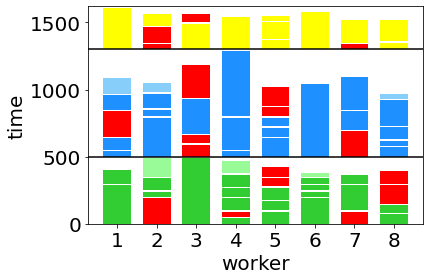

In [7]:
savefig_path = r"C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\DynamicScheduling.pdf"
isPPP=False
draw_source=False
smooth_tips=False

generate_picture(testdata_source, colordict, savefig_path, isPPP, draw_source,
                    Nacceptances, Nworkers, smooth_tips)

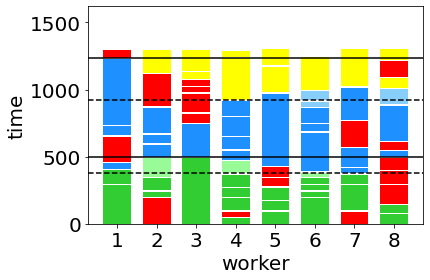

In [8]:
savefig_path = r"C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\DynamicSchedulingPPP.pdf"
isPPP = True
y_max = 1620
generate_picture(testdata_source, colordict, savefig_path, isPPP, draw_source,
                    Nacceptances, Nworkers, smooth_tips, y_max=y_max)

In [9]:
testdata_1gen=testdata_source.loc[testdata_source['Generation']==1].loc[testdata_source['Status']!="Discarded"]

i=testdata_1gen["Process Number"].max()
testdata_1gen = testdata_1gen.loc[0:24]
#row_value = [29, 1, "Accepted", 1, 150]
#testdata_1gen.append(row_value)
#testdata1gen=Insert_row_(26,testdata_1gen, row_value)
j=testdata_source.columns.get_loc('Worker #')
for i in range(len(testdata_1gen)):
    testdata_1gen.iloc[i,j]=np.random.randint(1,9)


In [10]:
def assign_static(testdata: pd.DataFrame,
                   isPPP: bool,
                   smooth_tips: bool,
                   Nworkers: int,
                   Ngenerations: int,
                   Nacceptances: int):
    
    current_gen=0
    workerclocks = np.zeros(Nworkers)
    current_acceptances = 0
    
    i=0
    
    indexworkercol=testdata_source.columns.get_loc('Worker #')
    indexstatuscol=testdata_source.columns.get_loc('Status')

    while i < len(testdata):

        freeworker = workerclocks.argmin() + 1
        testdata.iloc[i, indexworkercol] = freeworker
        
        #check acceptance
        
        if testdata.iloc[i, indexstatuscol]== "Accepted":
            
            workerclocks[freeworker - 1] += 1
            
            if current_acceptances < Nacceptances:
                current_acceptances += 1
            else:
                testdata.iloc[i,indexstatuscol]="Discarded"
        
        i += 1
    
    return testdata

def generate_static(testdata_source: pd.DataFrame, 
                     colordict: dict, 
                     path: str, 
                     isPPP: bool, 
                     draw_source: bool,
                     Nacceptances: int, 
                     Nworkers: int,
                     smooth_tips: bool,
                     y_max: int=0):
    
    Ngenerations = int(testdata_source['Generation'].max())    
    
    if draw_source:
        testdata=testdata_source
    else:
        testdata = assign_static(testdata_source, isPPP, smooth_tips, Nworkers, Ngenerations, Nacceptances)
    
    if Nworkers==0:
        Nworkers = int(testdata['Worker #'].max())
        
    walltimes, processes = find_walltimes(testdata, Nworkers, Ngenerations)
    
    Nmax_proc = int(processes.max())
    
    runtimes_wp, generations_wp, acceptance_wp = create_arrays(testdata, Nworkers, Ngenerations, Nmax_proc)
    
    colortable = create_colortable(colordict, generations_wp, acceptance_wp, Nworkers, Nmax_proc)
    
    draw_picture(path, colordict, colortable, runtimes_wp,
                 walltimes, Nworkers, Ngenerations, Nmax_proc, isPPP, y_max=y_max)

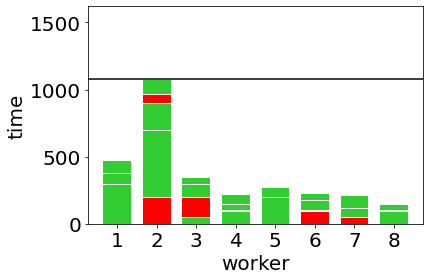

In [11]:
savefig_path = r"C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\StaticScheduling.pdf"
ymax=1620
generate_static(testdata_1gen, colordict, savefig_path, isPPP, draw_source,
                    Nacceptances, Nworkers, smooth_tips, y_max=ymax)

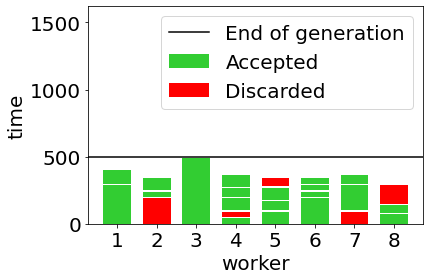

In [12]:
draw_source = False
smooth_tips = False 
savefig_path = r"C:\Users\Felipe\Documents\Uni\Master\Thesis\Scheduling\DynamicScheduling1Gen.pdf"

generate_picture(testdata_1gen, colordict, savefig_path, isPPP, draw_source,
                    Nacceptances, Nworkers, smooth_tips, y_max=ymax, legend=True)